In [1]:
# import os
# os.environ['PYOPENGL_PLATFORM']='osmesa'

import argparse
import pickle
import sys
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
# from gta_utils import LIMBS, read_depthmap
# from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob


import argparse

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import sys
sys.path.append('../')
sys.path.append('../../src')

from benji_prox_dataloader import *
from utils import *
from visualisation import *
from simple_transformer import PoseTransformer
import torch


import wandb
from scipy.ndimage import gaussian_filter1d



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


c:\Users\benja\Anaconda3\envs\torch3d\lib\site-packages\tqdm-4.64.0-py3.9.egg\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy: 1.21.5


In [2]:

root_dir = "D:/prox_data"

smplx_model_path='../../models_smplx_v1_1/models/'
in_frames=15
pred_frames=30
frame_jump=10
window_overlap_factor=8
lr = 0.0001
n_iter = 100

pd = proxDatasetJoints(root_dir=root_dir + '/PROXD_attempt2/PROXD', in_frames=in_frames, pred_frames=pred_frames, \
                       output_type='joint_locations', smplx_model_path=smplx_model_path, frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)
pdc = DatasetBase(root_dir=root_dir + '/recordings', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='Color', extra_prefix='', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)
pd2 = DatasetBase(root_dir=root_dir + '/PROXD_attempt2/PROXD', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='results', extra_prefix='joints_worldnorm.pkl', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)


print(len(pd), len(pdc))
pd.align(pdc)
pdc.align(pd)
print(len(pd), len(pdc))
pd2.align(pd)
pd.align(pd2)
print(len(pd), len(pd2))

# pdi = proxDatasetImages(root_dir="/cluster/scratch/bdayan/prox_data/recordings", in_frames=in_frames, pred_frames=pred_frames)

# dataloader = DataLoader(pd, batch_size=batch_size,
#                         shuffle=True, num_workers=0, collate_fn=my_collate)

1150 1338
1169 1169
1169 1169


In [56]:
import wandb
run_path = "vh-motion-pred/rnn/6n2zto4b"
api = wandb.Api()
run = api.run(run_path)

save_path = 'saves/GRU_joints_15_30_3fps_24_05_1854_epoch199_bn39.pt'
wandb.restore(save_path, run_path=run_path)

gru = PoseGRU_inputFC2(input_size=(25,3))
restore_dict = torch.load(save_path)
gru.load_state_dict(restore_dict['model_state_dict'])

<_io.TextIOWrapper name='c:\\Users\\benja\\coding\\eth\\prox\\virtual_huams_resource\\notebooks_neat\\saves/GRU_joints_15_30_3fps_24_05_1854_epoch199_bn39.pt' mode='r' encoding='cp1252'>

<All keys matched successfully>

In [6]:
def plot_run_loss(run, samples=500):
    df = run.history(samples=samples)
    loss = df.MSEloss[df.MSEloss < 5.]
    rep_loss = df.rep_pred_MSEloss[df.MSEloss < 5.]
    sigma = 10
    loss2 = gaussian_filter1d(loss, sigma=sigma)
    rep_loss2 = gaussian_filter1d(rep_loss, sigma=sigma)
    # plt.plot(np.log(loss2), label='loss')
    # plt.plot(np.log(rep_loss2), label='reploss')
    plt.plot(loss2, label='loss')
    plt.plot(rep_loss2, label='reploss')
    plt.legend()
    plt.title(run.name)


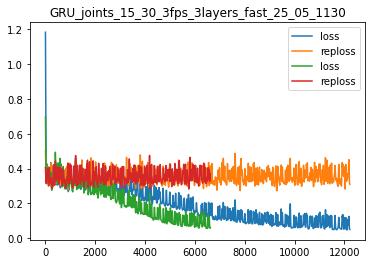

In [ ]:
run_path = "vh-motion-pred/rnn/6n2zto4b"
api = wandb.Api()
run = api.run(run_path)
plot_run_loss(run, samples=14000)

run_path = "benjidayan/vh-human-motion-pred/3a2yuk8h"
api = wandb.Api()
run = api.run(run_path)
plot_run_loss(run, samples=8000)

In [ ]:
run_path = "benjidayan/vh-human-motion-pred/runs/180xw98u"
api = wandb.Api()
run = api.run(run_path)

In [ ]:
df = run.history(samples=12000)
df.shape

(12000, 5)

In [ ]:
df

,_step,rep_pred_MSEloss,_runtime,MSEloss,_timestamp
0,0,0.305209,19,3.125528,1653411338
1,1,0.302613,23,1.528405,1653411342
2,2,0.442288,27,1.243104,1653411346
3,4,0.264223,35,0.826105,1653411354
4,6,2.790735,42,3.153611,1653411361
...,...,...,...,...,...
11995,15386,0.379915,42940,0.050516,1653454259
11996,15387,0.254375,42942,0.048994,1653454261
11997,15388,0.595751,42944,0.049397,1653454263
11998,15389,0.190761,42947,0.048757,1653454266


In [71]:
pd.output_type = 'joint_locations'
idx, in_joint_locations, pred_joint_locations = pd.__getitem__(50)
pd.output_type = 'raw_pkls'
(idx, (in_joint_fns, in_joint_data), (pred_joint_fns, pred_joint_data)) = pd.__getitem__(50)
in_frames_dicts, in_frames_fns, pred_frames_dicts, pred_frames_fns = pdc.__getitem__(50)
in_pkl_fns, in_pkls, pred_pkl_fns, pred_pkls = pd2.__getitem__(50)
in_skels_pkls, pred_skels_pkls = list(map(load, in_pkls)), list(map(load, pred_pkls))

in_frames = [np.array(cv2.imread(fn)) for fn in in_frames_fns]
pred_frames = [np.array(cv2.imread(fn)) for fn in pred_frames_fns]

In [9]:
pred_pkl_fns[:3]
pred_joint_fns[:3]
pred_frames_fns[:3]

[{'fn': 'D:\\prox_data\\PROXD_attempt2\\PROXD\\BasementSittingBooth_00145_01\\results\\s001_frame_01861__00.01.01.980\\joints_worldnorm.pkl',
  'frame': 1861,
  'tstamp': datetime.time(0, 1, 1, 980000)},
 {'fn': 'D:\\prox_data\\PROXD_attempt2\\PROXD\\BasementSittingBooth_00145_01\\results\\s001_frame_01871__00.01.02.312\\joints_worldnorm.pkl',
  'frame': 1871,
  'tstamp': datetime.time(0, 1, 2, 312000)},
 {'fn': 'D:\\prox_data\\PROXD_attempt2\\PROXD\\BasementSittingBooth_00145_01\\results\\s001_frame_01881__00.01.02.648\\joints_worldnorm.pkl',
  'frame': 1881,
  'tstamp': datetime.time(0, 1, 2, 648000)}]

['D:\\prox_data\\PROXD_attempt2\\PROXD\\BasementSittingBooth_00145_01\\results\\s001_frame_01861__00.01.01.980\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\BasementSittingBooth_00145_01\\results\\s001_frame_01871__00.01.02.312\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\BasementSittingBooth_00145_01\\results\\s001_frame_01881__00.01.02.648\\000.pkl']

['D:\\prox_data\\recordings\\BasementSittingBooth_00145_01\\Color\\s001_frame_01861__00.01.01.980.jpg',
 'D:\\prox_data\\recordings\\BasementSittingBooth_00145_01\\Color\\s001_frame_01871__00.01.02.312.jpg',
 'D:\\prox_data\\recordings\\BasementSittingBooth_00145_01\\Color\\s001_frame_01881__00.01.02.648.jpg']

In [4]:
in_skels_world = torch.stack(in_skels_pkls).squeeze()
in_skels_world.shape

torch.Size([15, 25, 3])

torch.Size([15, 25, 3])

In [9]:
in_skels = [normalized_joint_locations1(data, body_model=pd.body_model) for data in in_joint_data]
in_skels = torch.concat(in_skels)
in_skels.shape

torch.Size([15, 25, 3])

In [61]:
import json
from preprocess_world_joints import get_joints

with open(root_dir + '/cam2world/BasementSittingBooth.json') as file:
    cam2world = np.array(json.load(file))
    cam2world = torch.from_numpy(cam2world).float()

def data_dict_to_joint_locs(in_data_dict, body_model):
    betas, body_pose, global_orient, transl = extract_data(in_data_dict)
    out = body_model(return_joints=True, betas=betas, body_pose=body_pose, global_orient=global_orient, transl=transl)
    joint_locs = out.joints[:, :25]  # 1, 25, 3
    return joint_locs

def cam2world_conv(joint_locs: torch.Tensor, cam2world):
    """joints: ? x n x 3 or n x 3 I think"""
    if len(joint_locs.shape) == 2:
        joint_locs = joint_locs.unsqueeze(0)
    if len(joint_locs.shape) != 3:
        raise Exception('shape should be length 2 or 3')

    cam_R = cam2world[:3, :3].reshape([3, 3])
    cam_t = cam2world[:3, 3].reshape([1, 3])
    joint_locs = torch.matmul(cam_R, joint_locs.permute(0, 2, 1)).permute(0, 2, 1) + cam_t
    return joint_locs

def world2cam_conv(joint_locs: torch.Tensor, cam2world: torch.tensor):
    """joints: ? x n x 3 or n x 3 I think"""
    if len(joint_locs.shape) == 2:
        joint_locs = joint_locs.unsqueeze(0)
    if len(joint_locs.shape) != 3:
        raise Exception('shape should be length 2 or 3')

    cam_R = cam2world[:3, :3].reshape([3, 3])
    cam_t = cam2world[:3, 3].reshape([1, 3])
    joint_locs = torch.matmul(torch.inverse(cam_R), (joint_locs - cam_t).permute(0, 2, 1)).permute(0, 2, 1)
    return joint_locs


temp = torch.matmul(R, in_skels.permute(0, 2, 1)).permute(0, 2, 1) + t
temp2 = torch.matmul(torch.inverse(R), (temp - t).permute(0,2,1)).permute(0,2,1)


in_skels = [data_dict_to_joint_locs(data, body_model=pd.body_model) for data in in_joint_data]
fut_skels = [data_dict_to_joint_locs(data, body_model=pd.body_model) for data in pred_joint_data]
in_skels = torch.concat(in_skels)
fut_skels = torch.concat(fut_skels)
in_skels.shape

in_skels_world = torch.stack(in_skels_pkls).squeeze()
in_skels_world.shape

in_skels2 = world2cam_conv(in_skels_world, cam2world)


#######

in_skels_world2 = cam2world_conv(in_skels, cam2world)

torch.max(torch.abs(in_skels_world - in_skels_world2))
torch.max(torch.abs(in_skels - in_skels2))

torch.Size([15, 25, 3])

torch.Size([15, 25, 3])

tensor(0., grad_fn=<MaxBackward1>)

tensor(5.3644e-07, grad_fn=<MaxBackward1>)

In [65]:
cur_state, pred_skels_world = gru.forward_prediction(in_skels_world.unsqueeze(0), pred_len=30)
pred_skels_world.shape
pred_skels_world = pred_skels_world.squeeze()  # (30, 25, 3)
pred_skels_world.shape

torch.Size([1, 30, 25, 3])

torch.Size([30, 25, 3])

In [67]:
pred_skels = world2cam_conv(pred_skels_world, cam2world)
# pred_skels - fut_skels

In [82]:
body_color, body_depth, out_img = render_mesh_on_image(vertices = pred_skels[0].detach().numpy(), img= pred_frames[0], mesh_color=(1.0, 1.0, 0.9, 1.0))
  

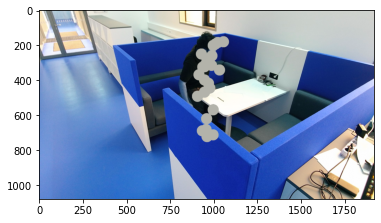

In [83]:
plt.imshow(out_img)

In [84]:
body_color, body_depth, out_img = render_mesh_on_image(vertices = fut_skels[0].detach().numpy(), img= pred_frames[0], mesh_color=(1.0, 1.0, 0.9, 1.0))
  

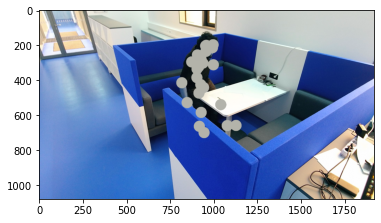

In [85]:
plt.imshow(out_img)

In [ ]:
cur_state, pred_skels = gru.forward_prediction(in_skels.unsqueeze(0), pred_len=30)
pred_skels.shape
pred_skels = pred_skels.squeeze()  # (30, 25, 3)
pred_skels.shape

In [46]:
cam_R = cam2world[:3, :3].reshape([3, 3])
cam_t = cam2world[:3, 3].reshape([1, 3])
R, t = cam_R, cam_t
R.shape, t.shape

temp = torch.matmul(R, in_skels.permute(0, 2, 1)).permute(0, 2, 1) + t
temp2 = torch.matmul(torch.inverse(R), (temp - t).permute(0,2,1)).permute(0,2,1)

torch.max(torch.abs(in_skels-temp2))

(torch.Size([3, 3]), torch.Size([1, 3]))

TypeError: 'module' object is not callable

In [50]:
temp = torch.matmul(R, in_skels.permute(0, 2, 1)).permute(0, 2, 1) + t
temp2 = torch.matmul(torch.inverse(R), (temp - t).permute(0,2,1)).permute(0,2,1)

In [52]:
torch.max(torch.abs(in_skels-temp2))

tensor(5.3644e-07, grad_fn=<MaxBackward1>)

In [45]:
x = torch.Tensor([1.1, -2.5, 3.4])
x2 = R @ x + t
x2.shape
x3 = torch.inverse(R) @ (x2 - t).squeeze()
x3

torch.Size([1, 3])

tensor([ 1.1000, -2.5000,  3.4000])

In [43]:
x2 - t

tensor([[-2.7952,  3.2969,  0.5810]])

In [23]:
torch.inverse(cam_R) @ cam_R

tensor([[ 1.0000e+00,  3.3528e-08, -8.0094e-08],
        [-3.7253e-09,  1.0000e+00, -2.9802e-08],
        [-1.8626e-08,  0.0000e+00,  1.0000e+00]])

In [25]:
def world2cam(joints: torch.Tensor, cam2world: torch.tensor):
    """joints: ? x 127 x 3 or ? x 25 x 3 I think"""
    joint_locs = joints[:, :25]
    cam_R = cam2world[:3, :3].reshape([3, 3])
    cam_t = cam2world[:3, 3].reshape([1, 3])
    joint_locs = torch.matmul(torch.inverse(cam_R), (joint_locs.permute - cam_t).permute(0, 2, 1)).permute(0, 2, 1)
    return joint_locs

cam_R = cam2world[:3, :3].reshape([3, 3])
cam_t = cam2world[:3, 3].reshape([1, 3])

joint_locs = in_skels_world

(joint_locs - cam_t).shape


torch.Size([15, 25, 3])

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        ...,

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
       

In [27]:
torch.max(torch.abs(in_skels_world - in_skels_world2))

tensor(0., grad_fn=<MaxBackward1>)

In [28]:
torch.max(torch.abs(in_skels - in_skels2))

tensor(1.2471, grad_fn=<MaxBackward1>)

In [13]:
skel2 = normalized_joint_locations1(in_joint_data[0], body_model=pd.body_model)
skel1 = in_joint_locations[0] + torch.Tensor(in_joint_data[-1]['transl'])
torch.max(torch.abs(skel1 - skel2))

tensor(2.3842e-07, grad_fn=<MaxBackward1>)

In [16]:
in_skels = in_joint_locations + torch.Tensor(in_joint_data[-1]['transl'])
import json

with open(root_dir + '/cam2world/BasementSittingBooth.json') as file:
    cam2world = np.array(json.load(file))
    cam2world = torch.from_numpy(cam2world).float()

in_skels2 = world2cam(in_skels_world.squeeze(), cam2world)

In [22]:
skel1.shape
in_skels2.shape
torch.max(torch.abs(skel1 - in_skels2[0]))

torch.Size([25, 3])

torch.Size([15, 25, 3])

tensor(1.0225, grad_fn=<MaxBackward1>)

In [17]:
from preprocess_world_joints import get_joints
joints0 = get_joints(in_joint_fns[0], pd.body_model, cam2world)
type(joints0)
joints0.shape

torch.Tensor

torch.Size([1, 25, 3])

In [27]:
joints0 - in_skels_world[0]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)

In [26]:
joint_locs = joints0[:, :25]
joint_locs.shape

def world2cam(joints: torch.Tensor, cam2world: torch.tensor):
    """joints: ? x 127 x 3 or ? x 25 x 3 I think"""
    joint_locs = joints[:, :25]
    cam_R = cam2world[:3, :3].reshape([3, 3])
    cam_t = cam2world[:3, 3].reshape([1, 3])
    joint_locs = torch.matmul(torch.inverse(cam_R), (joint_locs - cam_t).permute(0, 2, 1)).permute(0, 2, 1)
    return joint_locs


torch.Size([1, 25, 3])

In [25]:
world2cam(joints0, cam2world) - skel1

tensor([[[-2.8312e-07, -5.9605e-08,  2.3842e-07],
         [ 3.0966e-02, -7.7437e-02,  1.5586e-01],
         [ 3.7573e-02,  2.4524e-02, -2.5744e-03],
         [-1.1808e-01, -1.3153e-02, -9.5319e-02],
         [ 5.4282e-01, -4.1009e-02,  6.0234e-01],
         [ 6.2771e-02,  3.5155e-03,  5.6295e-02],
         [-2.3792e-01, -2.7582e-02, -1.9031e-01],
         [ 6.8173e-01, -8.6729e-02,  8.1347e-01],
         [ 1.5195e-02, -8.6274e-02,  1.5458e-01],
         [-2.6433e-01,  9.6232e-04, -2.6256e-01],
         [ 8.0720e-01, -1.3932e-01,  1.0225e+00],
         [ 1.6961e-01, -6.5095e-02,  2.7279e-01],
         [-4.8631e-01, -4.1646e-02, -4.1282e-01],
         [-3.5312e-01, -4.2034e-02, -2.8068e-01],
         [-3.8705e-01,  5.0818e-03, -3.9040e-01],
         [-5.5491e-01,  1.5054e-02, -5.7229e-01],
         [-4.3947e-01, -1.2935e-01, -2.2466e-01],
         [-5.3719e-01,  6.4895e-03, -5.4094e-01],
         [-3.7369e-01, -3.4650e-01,  1.9160e-01],
         [-5.4966e-01,  9.1974e-02, -6.9155e-01],


In [19]:
in_skels_world[:1] - joints0

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)

In [93]:
import json
from preprocess_world_joints import get_joints


area_name = 'BasementSittingBooth'
with open(root_dir + '/cam2world/' + area_name + '.json') as file:
    cam2world = np.array(json.load(file))
    cam2world = torch.from_numpy(cam2world).float()

in_skels_world = []
for fn in in_joint_fns:
    joints = get_joints(fn, pd.body_model, cam2world)
    in_skels_world.append(joints)

in_skels_world = torch.stack(in_skels_world).squeeze()
pelvis = in_skels_world[0, 0, :]
in_skels_world.shape
pelvis.shape
in_skels = in_skels_world - pelvis

torch.Size([15, 25, 3])

torch.Size([3])

In [96]:
in_skels_rgb = in_joint_locations + torch.Tensor(in_joint_data[-1]['transl'])

In [98]:
torch.abs(in_skels_rgb - world2cam(in_skels_world, cam2world)).max()

tensor(0.2065, grad_fn=<MaxBackward1>)

In [78]:
cur_state, pred_skels = gru.forward_prediction(in_skels.unsqueeze(0), pred_len=30)
pred_skels.shape
pred_skels = pred_skels.squeeze()  # (30, 25, 3)
pred_skels.shape

torch.Size([1, 30, 25, 3])

torch.Size([30, 25, 3])

In [82]:
from utils import world2cam
pred_skels_world = torch.Tensor(pred_skels) + pelvis
pred_skels_rgb = world2cam(pred_skels_world, cam2world).detach().numpy()

In [83]:
body_color, body_depth, output_img = render_mesh_on_image(vertices = pred_skels_rgb[0], faces=None, img=pred_frames[0], mesh_color=(1.0, 0.3, 0.3, 1.0))

ValueError: operands could not be broadcast together with shapes (1080,1920,4) (1080,1920,3) 

In [85]:
vertices = pred_skels_rgb[0]
faces=None
img = pred_frames[0]
mesh_color=(1.0, 0.3, 1.0, 1.0)

out_mesh = trimesh.Trimesh(vertices, faces, process=False) if faces is not None else \
    pyrender.Mesh.from_points(vertices, colors=[mesh_color]*len(vertices))


# common
H, W = 1080, 1920  # TODO these better be the same as image shape

r = pyrender.OffscreenRenderer(viewport_width=W,
                        viewport_height=H,
                        point_size=1.0 if faces is not None else 17.0)  # 1.0 too small for skeleton

camera_center = np.array([951.30, 536.77])  # Idk why these, do be quite close to halfway point
camera_pose = np.eye(4)
camera_pose = np.array([1.0, -1.0, -1.0, 1.0]).reshape(-1, 1) * camera_pose
camera = pyrender.camera.IntrinsicsCamera(
    fx=1060.53, fy=1060.38,
    cx=camera_center[0], cy=camera_center[1])
light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)

material = pyrender.MetallicRoughnessMaterial(
    metallicFactor=0.0,
    alphaMode='OPAQUE',
    baseColorFactor=mesh_color)
if faces is not None:
    out_mesh = pyrender.Mesh.from_trimesh(
        out_mesh, material=material)

## rendering body
if img is not None:
    H2, W2, _ = img.shape
    assert(H2 == H and W2 == W)

scene = pyrender.Scene(bg_color=[0.0, 0.0, 0.0, 0.0],
                    ambient_light=(0.3, 0.3, 0.3))
scene.add(camera, pose=camera_pose)
scene.add(light, pose=camera_pose)
# for node in light_nodes:
#     scene.add_node(node)

scene.add(out_mesh, 'mesh')

body_color, body_depth = r.render(scene,)# flags=pyrender.RenderFlags.RGBA)
body_color = body_color.astype(np.float32)  / 255.0

valid_mask = (body_color > 0)
input_img = img if img is not None else np.zeros(body_color.shape)
output_img = (body_color * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)  # image is reversed for whatever reason


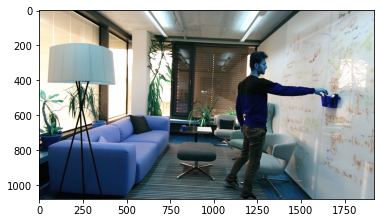

In [86]:
plt.imshow(output_img)

(array([[ 3., 18.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 9.,  6.,  4.,  2.,  2.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5., 20.]]),
 array([-0.47503012, -0.16501018,  0.14500976,  0.4550297 ,  0.76504964,
         1.0750695 ,  1.3850895 ,  1.6951095 ,  2.0051293 ,  2.3151493 ,
         2.6251693 ], dtype=float32),
 <a list of 3 BarContainer objects>)

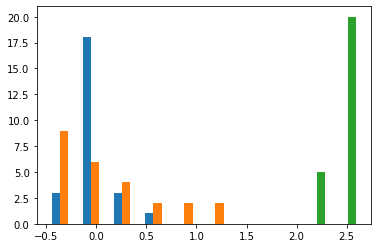

In [87]:
plt.hist(pred_skels_rgb[0])

In [20]:
body_color.shape

(1080, 1920, 3)

In [10]:
np.zeros(pred_skels.shape).shape

(30, 25, 3)

In [11]:
in_joint_locations.detach().numpy()

array([[[-0.02523312, -0.357034  ,  0.01448449],
        [ 0.03791995, -0.26955137,  0.04794437],
        [-0.07856911, -0.2484079 ,  0.04358787],
        ...,
        [-0.08141637, -0.981198  , -0.05522548],
        [-0.03580889, -0.99366295, -0.13432646],
        [-0.099594  , -0.9916709 , -0.1414531 ]],

       [[-0.02627282, -0.3585436 ,  0.02209743],
        [ 0.03678724, -0.27060276,  0.05451522],
        [-0.07976676, -0.24977657,  0.05037251],
        ...,
        [-0.08121872, -0.9834146 , -0.0426495 ],
        [-0.03553732, -0.9966382 , -0.12158445],
        [-0.09931092, -0.994612  , -0.128804  ]],

       [[-0.02645515, -0.35873714,  0.02065762],
        [ 0.03668245, -0.27079648,  0.05292476],
        [-0.07985577, -0.2498835 ,  0.04877561],
        ...,
        [-0.08191061, -0.98366344, -0.04311091],
        [-0.03625256, -0.9970459 , -0.12203261],
        [-0.10002571, -0.9949806 , -0.12924498]],

       ...,

       [[-0.00153979, -0.36395362,  0.0181919 ],
        [ 0

In [12]:
in_joint_data[-1]['transl']

array([[-0.01682262,  0.572983  ,  2.422782  ]], dtype=float32)

In [13]:
from utils import extract_data
new_joint_locations = []
for data_dict in in_joint_data:
    betas, body_pose, euler_angles, transl = extract_data(data_dict)
    out = pd.body_model(return_joints=True, betas=betas, body_pose=body_pose, global_orient=euler_angles, transl=transl)
    new_joint_locations.append(out.joints.detach().numpy().squeeze()[:25, :])

In [14]:
new_joint_locations[0].shape

(25, 3)

In [18]:
# skeleton_frames = in_joint_locations.detach().numpy()
# skeleton_frames = [skel + in_joint_data[-1]['transl'] for skel in skeleton_frames]

skeleton_frames = new_joint_locations
input_img = in_frames[0]
H, W = input_img.shape[:2]

# trans = np.eye(4)
# trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
# rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
# ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
# rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# # trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# # trans[:3, -1] = np.array([0, 0, -3])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz
# trans[:3, -1] = np.array([5, 0, 3])


camera_center = np.array([951.30, 536.77])  # Idk why these, do be quite close to halfway point
camera_pose = np.eye(4)
camera_pose = np.array([1.0, -1.0, -1.0, 1.0]).reshape(-1, 1) * camera_pose
# camera = pyrender.camera.IntrinsicsCamera(
#     fx=1060.53, fy=1060.38,
#     cx=camera_center[0], cy=camera_center[1])
camera = o3d.camera.PinholeCameraIntrinsic(width = W, height=H, fx=1060.38, fy=1060.38, cx=camera_center[0], cy=camera_center[1])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
_ = vis.create_window(visible=True, width=W, height=H)
_ = vis.add_geometry(mesh_frame)  
outputs = []
for t in range(skeleton_frames.shape[0]):  
    print(t)


    # ctr = vis.get_view_control()
    # cam_param2 = o3d.camera.PinholeCameraParameters()
    # cam_param2.intrinsic = camera
    # cam_param2.extrinsic = camera_pose
    # ctr.convert_from_pinhole_camera_parameters(cam_param2, True)

    _ = vis.poll_events()
    _ = vis.update_renderer()
    t = 0
    skeleton_input = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(skeleton_frames[t]),
        lines=o3d.utility.Vector2iVector(LIMBS))
    skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

    vis.add_geometry(skeleton_input)

    _ = vis.poll_events()
    _ = vis.update_renderer()
    time.sleep(1.0)
    vis.remove_geometry(skeleton_input)

# out = np.array(vis.capture_screen_float_buffer())

# valid_mask = (body_color > 0)
# input_img = img if img is not None else np.zeros(body_color.shape)
# output_img = (body_color * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)  # image is reversed for whatever reason

# valid_mask = (out.mean(axis=-1) != 1).reshape(1080, 1920, 1)
# # input_img = img if img is not None else np.zeros(body_color.shape)
# output_img = (out * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)  # image is reversed for whatever reason


# vis.remove_geometry(skeleton_input)
# plt.figure(figsize=(10,10))
# plt.imshow(output_img)

AttributeError: 'list' object has no attribute 'shape'

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\benja\Anaconda3\envs\torch3d\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\benja\Anaconda3\envs\torch3d\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\benja\Anaconda3\envs\torch3d\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\benja\Anaconda3\envs\torch3d\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError

: 

In [16]:
# skeleton_frames = in_joint_locations.detach().numpy()
# skeleton_frames = [skel + in_joint_data[-1]['transl'] for skel in skeleton_frames]

skeleton_frames = new_joint_locations
input_img = in_frames[0]
H, W = input_img.shape[:2]

trans = np.eye(4)
trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# trans[:3, -1] = np.array([0, 0, -3])
trans[:3, :3] = trans[:3, :3]@rz@rz@rz
trans[:3, -1] = np.array([5, 0, 3])


camera_center = np.array([951.30, 536.77])  # Idk why these, do be quite close to halfway point
camera_pose = np.eye(4)
camera_pose = np.array([1.0, -1.0, -1.0, 1.0]).reshape(-1, 1) * camera_pose
# camera = pyrender.camera.IntrinsicsCamera(
#     fx=1060.53, fy=1060.38,
#     cx=camera_center[0], cy=camera_center[1])
camera = o3d.camera.PinholeCameraIntrinsic(width = W, height=H, fx=1060.38, fy=1060.38, cx=camera_center[0], cy=camera_center[1])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
# vis = o3d.visualization.Visualizer()
# _ = vis.create_window(visible=True, width=W, height=H)
vis = o3d.JVisualizer()
_ = vis.add_geometry(mesh_frame)  
outputs = []
# for t in range(skeleton_frames.shape[0]):  
#     print(t)


# ctr = vis.get_view_control()
# cam_param2 = o3d.camera.PinholeCameraParameters()
# cam_param2.intrinsic = camera
# cam_param2.extrinsic = camera_pose
# ctr.convert_from_pinhole_camera_parameters(cam_param2, True)

_ = vis.poll_events()
_ = vis.update_renderer()
t = 0
skeleton_input = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(skeleton_frames[t]),
    lines=o3d.utility.Vector2iVector(LIMBS))
skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

vis.add_geometry(skeleton_input)

_ = vis.poll_events()
_ = vis.update_renderer()

vis.run()

# out = np.array(vis.capture_screen_float_buffer())

# # valid_mask = (body_color > 0)
# # input_img = img if img is not None else np.zeros(body_color.shape)
# # output_img = (body_color * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)  # image is reversed for whatever reason

# valid_mask = (out.mean(axis=-1) != 1).reshape(1080, 1920, 1)
# # input_img = img if img is not None else np.zeros(body_color.shape)
# output_img = (out * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)  # image is reversed for whatever reason


# vis.remove_geometry(skeleton_input)
# plt.figure(figsize=(10,10))
# plt.imshow(output_img)

AttributeError: module 'open3d' has no attribute 'JVisualizer'

In [84]:
ctr = vis.get_view_control()
cam_param = ctr.convert_to_pinhole_camera_parameters()

cam_param2 = o3d.camera.PinholeCameraParameters()
cam_param2.intrinsic = camera
cam_param2.extrinsic = camera_pose
ctr.convert_from_pinhole_camera_parameters(cam_param2)

In [86]:
cam_param2.intrinsic = camera
cam_param2.extrinsic = camera_pose

In [82]:
cam_param.intrinsic.intrinsic_matrix
cam_param.extrinsic

camera.intrinsic_matrix
camera_pose

array([[935.30743609,   0.        , 959.5       ],
       [  0.        , 935.30743609, 539.5       ],
       [  0.        ,   0.        ,   1.        ]])

array([[ 1.        ,  0.        ,  0.        , -0.235     ],
       [-0.        , -1.        , -0.        ,  0.235     ],
       [-0.        , -0.        , -1.        ,  0.87759085],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

array([[1.06038e+03, 0.00000e+00, 9.51300e+02],
       [0.00000e+00, 1.06038e+03, 5.36770e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]])

array([[ 1.,  0.,  0.,  0.],
       [-0., -1., -0., -0.],
       [-0., -0., -1., -0.],
       [ 0.,  0.,  0.,  1.]])

In [78]:
cam_param
camera

PinholeCameraParameters class.
Access its data via intrinsic and extrinsic.

PinholeCameraIntrinsic with width = 1920 and height = 1080.
Access intrinsics with intrinsic_matrix.

In [ ]:
ctr.convert_from_pinhole_camera_parameters(cam_param)

In [43]:
temp = out.mean(axis=-1) == 1
out.shape
temp.shape
np.mean(temp)

(1080, 1920, 3)

(1080, 1920)

0.993954475308642

In [45]:
out * valid_mask

ValueError: operands could not be broadcast together with shapes (1080,1920,3) (1080,1920) 

In [46]:
input_img = in_frames[0]
valid_mask = (out.mean(axis=-1) != 1).reshape(1080, 1920, 1)
# input_img = img if img is not None else np.zeros(body_color.shape)
output_img = (out * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)  # image is reversed for whatever reason


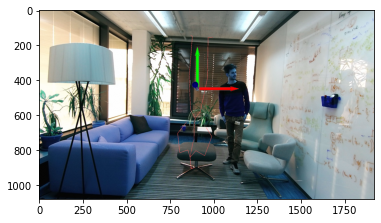

In [47]:
plt.imshow(output_img)

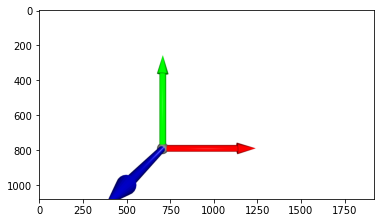

In [25]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
_ = vis.create_window(visible=False)
_ = vis.add_geometry(mesh_frame)  
_ = vis.poll_events()
_ = vis.update_renderer()
out = vis.capture_screen_float_buffer()
plt.imshow(out)

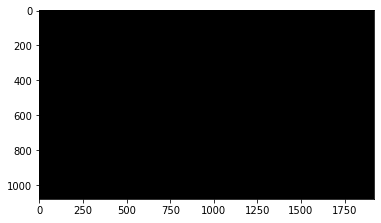

In [24]:
plt.imshow(np.asarray(outputs[0]))

In [5]:
in_joint_fns

['/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01749__00.00.58.270/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01754__00.00.58.435/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01759__00.00.58.604/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01764__00.00.58.768/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01769__00.00.58.936/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01774__00.00.59.107/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01779__00.00.59.270/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01784__00.00.59.440/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01789__00.00.59.603/000.pkl',
 '/cluster/scratch/bdayan/prox_data/P

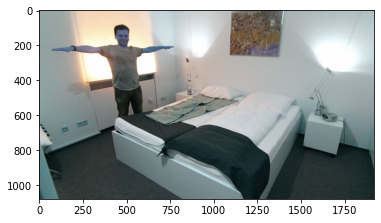

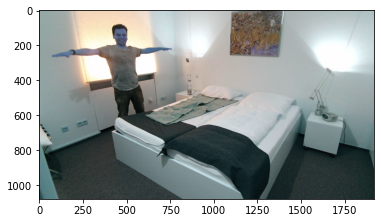

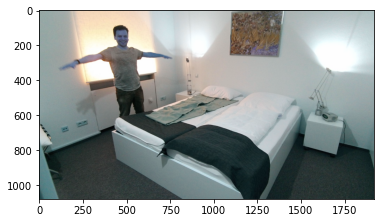

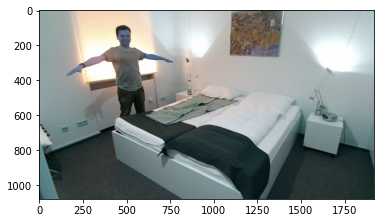

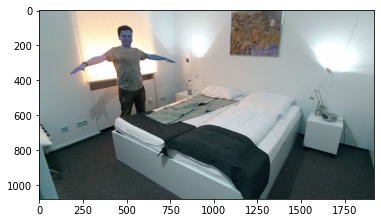

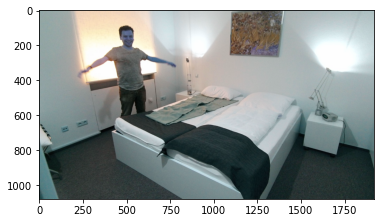

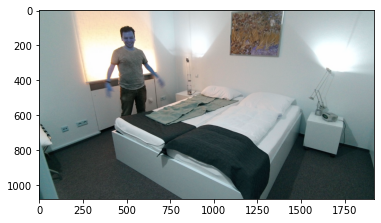

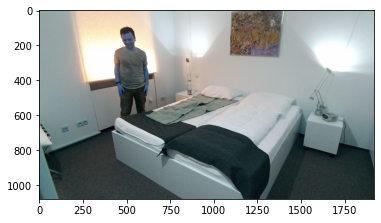

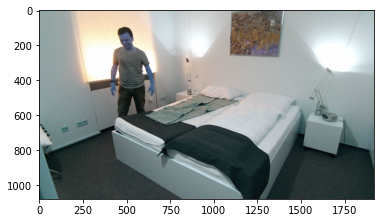

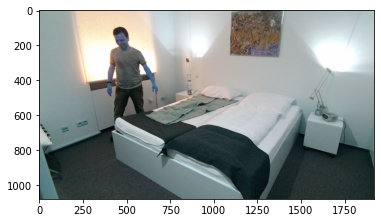

In [6]:
for img in in_frames:
    _ = plt.figure()
    _ = plt.imshow(img)

In [9]:
outputs = smplx_and_background_to_video(in_frames, in_joint_data, body_model=pd.body_model)

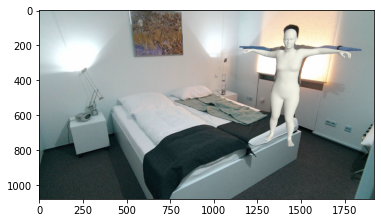

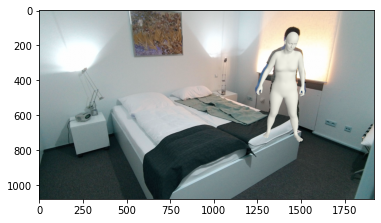

In [10]:
for im in [outputs[0], outputs[-1]]:
    _ = plt.figure()
    _ = plt.imshow(im)

In [11]:
from utils import *
pd.output_type='raw_pkls'
(idx, (in_frames_fns, in_data), (pred_frames_fns, pred_data)) = pd.__getitem__(500)
_betas, _body_pose, base_euler_angles, base_transl = extract_data(in_data[-1])

In [12]:
base_euler_angles

tensor([[-2.7733, -0.0070,  0.4914]])

In [ ]:
# from visualisation import *
# animate_skeleton(in_joint_locations.detach().numpy())

In [7]:
import pickle
with open('temp.pkl', 'wb') as file:
    pickle.dump([in_joint_data, in_joint_locations], file)

In [ ]:
skeleton_frames = in_joint_locations.detach().numpy()
trans = np.eye(4)
trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# trans[:3, -1] = np.array([0, 0, -3])
trans[:3, :3] = trans[:3, :3]@rz@rz@rz
trans[:3, -1] = np.array([5, 0, 3])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)

vis.add_geometry(mesh_frame)  

outs = []
for t in range(skeleton_frames.shape[0]):  
    print(t)
    vis.poll_events()
    vis.update_renderer()
    skeleton_input = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(skeleton_frames[t]),
        lines=o3d.utility.Vector2iVector(LIMBS))
    skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

    vis.add_geometry(skeleton_input)

    # ctr = vis.get_view_control()
    # cam_param = ctr.convert_to_pinhole_camera_parameters()
    # cam_param = update_cam(cam_param, trans)
    # ctr.convert_from_pinhole_camera_parameters(cam_param)

    vis.poll_events()
    vis.update_renderer()
    outs.append(np.asarray(vis.capture_screen_float_buffer()))
    vis.remove_geometry(skeleton_input)

True

In [ ]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  

vis.poll_events()
vis.update_renderer()
temp = vis.capture_screen_float_buffer(False)



True

In [4]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  

True

True

In [5]:
vis.poll_events()

True

In [ ]:
plt.imshow(np.asarray(temp))

In [ ]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame) 

vis.poll_events()
vis.update_renderer()

t=3

skeleton_frames = in_joint_locations.detach().numpy()
skeleton_input = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(skeleton_frames[t]),
    lines=o3d.utility.Vector2iVector(LIMBS))
skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

vis.add_geometry(skeleton_input)


vis.poll_events()
vis.update_renderer()
temp = vis.capture_screen_float_buffer(False)


True

In [ ]:
plt.imshow(temp)

In [5]:
skeleton_frames = in_joint_locations.detach().numpy()
trans = np.eye(4)
trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# trans[:3, -1] = np.array([0, 0, -3])
trans[:3, :3] = trans[:3, :3]@rz@rz@rz
trans[:3, -1] = np.array([5, 0, 3])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  
temp = vis.capture_screen_float_buffer(False)

False

In [6]:
vis.update_renderer()

In [ ]:
temp = vis.capture_screen_float_buffer(False)

In [8]:
base_euler_angles = in_data['global_orient']

NameError: name 'in_data' is not defined